In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")


# Define ResNet-18 architecture (using ResNet50 with custom layers)
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights=None  # No pretrained weights due to smaller input shape
    )
    model = Sequential([
        Input(shape=input_shape),
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define MobileNetV2 architecture
def build_mobilenet(input_shape=(32, 32, 3), num_classes=10):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights=None)  # No pretrained weights
    model = Sequential([
        Input(shape=input_shape),
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define AlexNet architecture
def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(96, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to [0, 1]
y_train = tf.keras.utils.to_categorical(y_train, 10)  # One-hot encode labels
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split training data into training and validation sets
x_train, x_val = x_train[:40000], x_train[40000:]
y_train, y_val = y_train[:40000], y_train[40000:]


In [3]:
# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


In [4]:
# Function to get a new instance of an optimizer
def get_optimizer(optimizer_name):
    if optimizer_name == 'Adam':
        return Adam(learning_rate=0.0001)
    elif optimizer_name == 'SGD':
        return SGD(learning_rate=0.001, momentum=0.9)
    else:
        raise ValueError("Optimizer name must be either 'Adam' or 'SGD'")

# Function to train and evaluate each model
def train_and_evaluate(model, model_name, optimizer_name, x_train, y_train, x_val, y_val):
    optimizer = get_optimizer(optimizer_name)  # Get a new optimizer instance
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Use try-except to capture any training errors and ensure cleanup
    try:
        history = model.fit(
            datagen.flow(x_train, y_train, batch_size=128),  
            epochs=8,  
            validation_data=(x_val, y_val),
            verbose=1
        )
    except Exception as e:
        print(f"Error during training {model_name} with {optimizer_name}: {e}")
        return None, None  # Return 8one to avoid further processing
    
    plot_history(history, model_name, optimizer_name)
    val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
    print(f'{model_name} with {optimizer_name}: Validation Accuracy = {val_accuracy:.4f}, Validation Loss = {val_loss:.4f}')
    return val_accuracy, val_loss


In [5]:
# Function to plot training and validation accuracy and loss
def plot_history(history, model_name, optimizer_name):
    if not history:
        return  # Skip if training was not successful

    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - {optimizer_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - {optimizer_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


Training ResNet-18 with Adam optimizer...
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.1259 - loss: 2.6843 - val_accuracy: 0.1076 - val_loss: 2.3954
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.1956 - loss: 2.1391 - val_accuracy: 0.2344 - val_loss: 2.0408
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.2391 - loss: 2.0421 - val_accuracy: 0.2970 - val_loss: 1.9195
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 862s 3s/step - accuracy: 0.2751 - loss: 1.9697 - val_accuracy: 0.3277 - val_loss: 1.8377
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.3036 - loss: 1.9002 - val_accuracy: 0.3590 - val_loss: 1.7614
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.3417 - loss: 1.8170 - val_accuracy: 0.3737 - val_loss: 1.7280
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 1248s 4s/step - accuracy: 0.3683 - loss: 1.7584 - val_accuracy: 0.4013 - val_loss: 1.6393
Epoch 8/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accurac

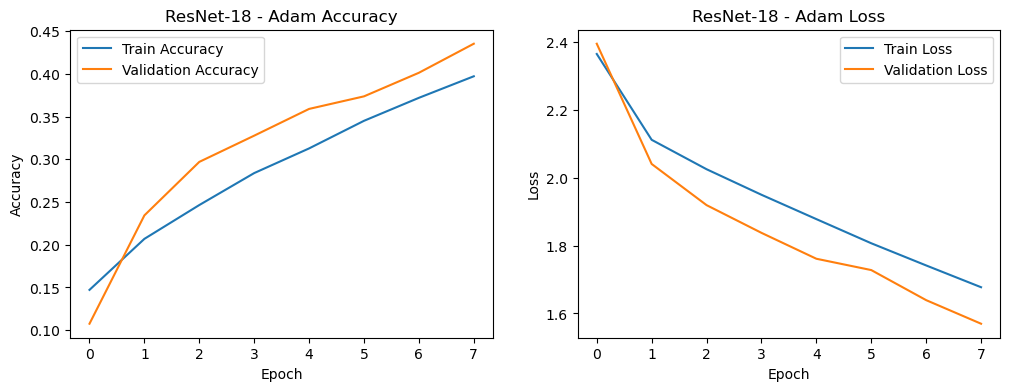

ResNet-18 with Adam: Validation Accuracy = 0.4353, Validation Loss = 1.5698
Training ResNet-18 with SGD optimizer...
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.3543 - loss: 1.7890 - val_accuracy: 0.3235 - val_loss: 2.0626
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.4168 - loss: 1.6101 - val_accuracy: 0.4053 - val_loss: 1.6533
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.4390 - loss: 1.5449 - val_accuracy: 0.4732 - val_loss: 1.4585
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.4668 - loss: 1.4886 - val_accuracy: 0.4285 - val_loss: 1.5386
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.4836 - loss: 1.4412 - val_accuracy: 0.4698 - val_loss: 1.5027
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 6683s 21s/step - accuracy: 0.4980 - loss: 1.4017 - val_accuracy: 0.5037 - val_loss: 1.4115
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 17073s 55s/step - accuracy: 0.5200 - loss: 1.3580 - val_accuracy: 0.5179 -

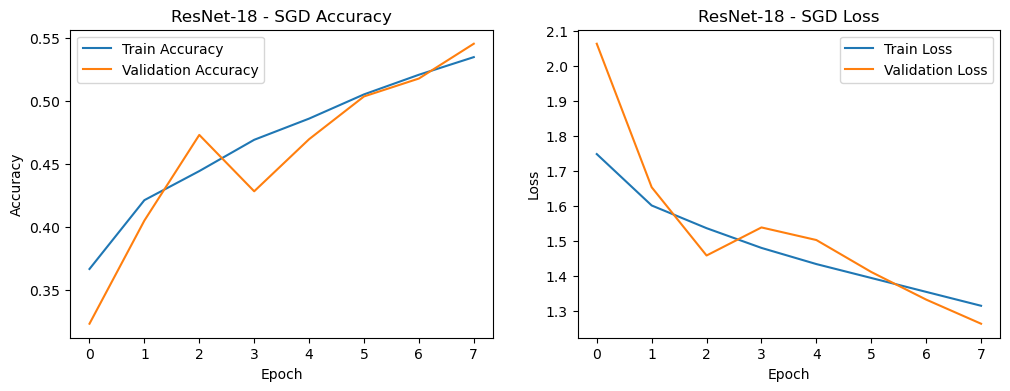

ResNet-18 with SGD: Validation Accuracy = 0.5455, Validation Loss = 1.2640
Training MobileNetV2 with Adam optimizer...
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.1184 - loss: 2.4307 - val_accuracy: 0.0997 - val_loss: 2.3028
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.1651 - loss: 2.2193 - val_accuracy: 0.1016 - val_loss: 2.3031
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.1993 - loss: 2.1410 - val_accuracy: 0.0977 - val_loss: 2.3030
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.2284 - loss: 2.0500 - val_accuracy: 0.0977 - val_loss: 2.3049
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.2500 - loss: 1.9932 - val_accuracy: 0.0977 - val_loss: 2.3073
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.2796 - loss: 1.9192 - val_accuracy: 0.0977 - val_loss: 2.3095
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.3029 - loss: 1.8687 - val_accuracy: 0.09

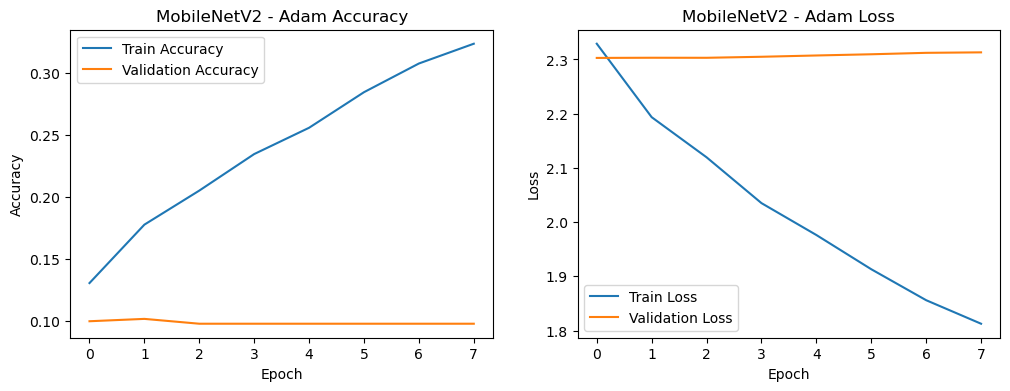

MobileNetV2 with Adam: Validation Accuracy = 0.0977, Validation Loss = 2.3130
Training MobileNetV2 with SGD optimizer...
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.3335 - loss: 1.8000 - val_accuracy: 0.0977 - val_loss: 2.3131
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.3776 - loss: 1.6747 - val_accuracy: 0.1016 - val_loss: 2.3152
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4191 - loss: 1.5798 - val_accuracy: 0.1016 - val_loss: 2.3202
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4362 - loss: 1.5464 - val_accuracy: 0.0952 - val_loss: 2.3256
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4633 - loss: 1.4713 - val_accuracy: 0.0952 - val_loss: 2.3176
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.4779 - loss: 1.4452 - val_accuracy: 0.0952 - val_loss: 2.3273
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4992 - loss: 1.3990 - val_accuracy: 0.

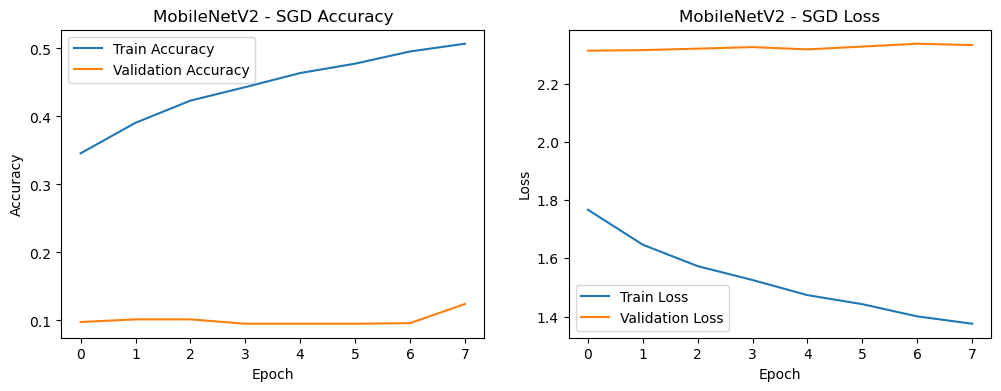

MobileNetV2 with SGD: Validation Accuracy = 0.1242, Validation Loss = 2.3324
Training AlexNet with Adam optimizer...
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.2394 - loss: 2.0681 - val_accuracy: 0.3915 - val_loss: 1.6855
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4034 - loss: 1.6423 - val_accuracy: 0.4592 - val_loss: 1.5150
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4521 - loss: 1.5130 - val_accuracy: 0.5023 - val_loss: 1.3888
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4798 - loss: 1.4487 - val_accuracy: 0.5231 - val_loss: 1.3531
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4998 - loss: 1.3921 - val_accuracy: 0.5163 - val_loss: 1.3640
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.5165 - loss: 1.3449 - val_accuracy: 0.5571 - val_loss: 1.2572
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.5368 - loss: 1.3021 - val_accuracy: 0.5753

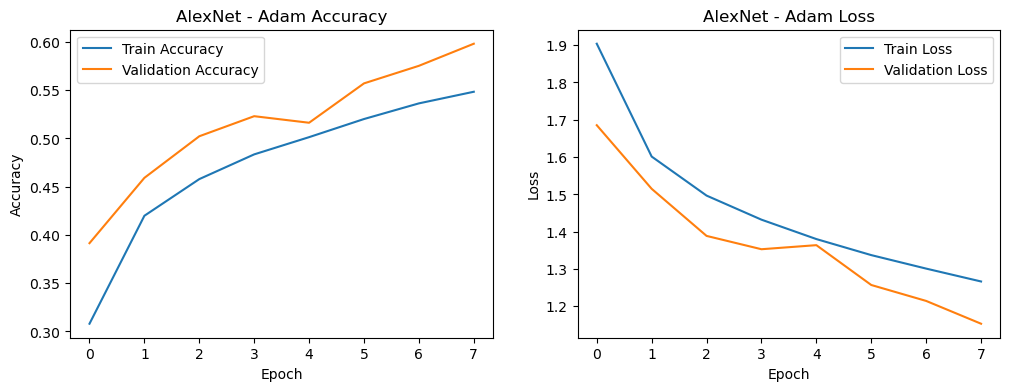

AlexNet with Adam: Validation Accuracy = 0.5982, Validation Loss = 1.1534
Training AlexNet with SGD optimizer...
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.5293 - loss: 1.3198 - val_accuracy: 0.5751 - val_loss: 1.2186
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.5474 - loss: 1.2747 - val_accuracy: 0.5879 - val_loss: 1.1595
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.5612 - loss: 1.2352 - val_accuracy: 0.6069 - val_loss: 1.1196
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.5664 - loss: 1.2376 - val_accuracy: 0.6004 - val_loss: 1.1360
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.5676 - loss: 1.2242 - val_accuracy: 0.6119 - val_loss: 1.1052
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.5697 - loss: 1.2130 - val_accuracy: 0.6003 - val_loss: 1.1494
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.5747 - loss: 1.1983 - val_accuracy: 0.6223 - v

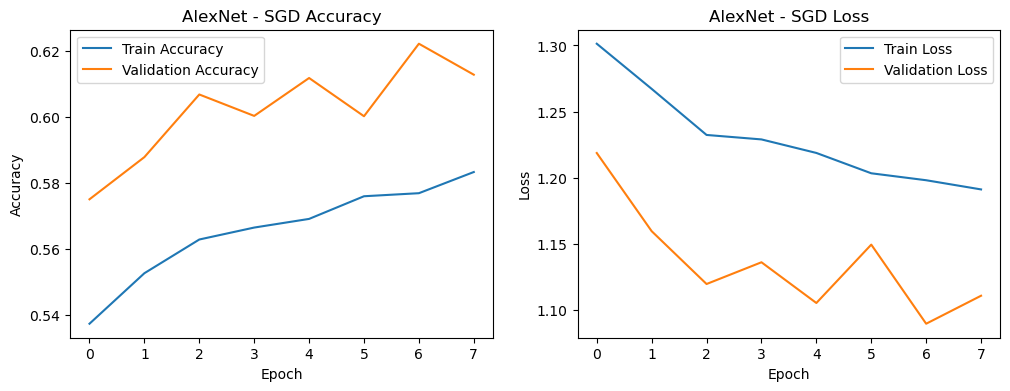

AlexNet with SGD: Validation Accuracy = 0.6129, Validation Loss = 1.1107


In [6]:
# Dictionary to hold model architectures
models = {
    'ResNet-18': build_resnet18(input_shape=(32, 32, 3), num_classes=10),
    'MobileNetV2': build_mobilenet(input_shape=(32, 32, 3), num_classes=10),
    'AlexNet': build_alexnet(input_shape=(32, 32, 3), num_classes=10)
}

# Dictionary to store results
results = {}

# Train each model with each optimizer
for model_name, model in models.items():
    for optimizer_name in ['Adam', 'SGD']:  # Specify optimizer names
        print(f'Training {model_name} with {optimizer_name} optimizer...')
        val_accuracy, val_loss = train_and_evaluate(model, model_name, optimizer_name, x_train, y_train, x_val, y_val)
        if val_accuracy is not None and val_loss is not None:
            results[(model_name, optimizer_name)] = (val_accuracy, val_loss)


In [7]:
# Find the best model and optimizer based on validation accuracy
if results:
    best_model_info = max(results, key=lambda x: results[x][0])
    best_model_name, best_optimizer_name = best_model_info
    best_model = models[best_model_name]
    best_optimizer = get_optimizer(best_optimizer_name)

    print(f"\nBest Model: {best_model_name} with {best_optimizer_name} optimizer")

    # Recompile best model with best optimizer and evaluate on the test set
    best_model.compile(optimizer=best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
    print(f'\nTest Accuracy of Best Model ({best_model_name} with {best_optimizer_name}): {test_accuracy:.4f}')
else:
    print("No valid results to display.")



Best Model: AlexNet with SGD optimizer

Test Accuracy of Best Model (AlexNet with SGD): 0.6115


In [ ]:
]